In [2]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries,make_distance_graph
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pickle
transfer = ["CH4@100 bar/298 K (mg/g)"]
interest=["H2@100 bar/77K (wt%)"]
new_list=[["H2@100 bar/77K (wt%)"],['H2@100 bar/243K (wt%)'],['CH4@100 bar/298 K (mg/g)']]
with open(f'{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}.pickle', 'rb') as f:
    figure_dic=pickle.load(f)

In [3]:
loud=[0,0,0,0,0,0]
#make clusters the same size with a random sample
resize=True
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID','H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)','topology']]=data[['MOF ID','H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)','topology']]
#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)','topology', 'Pc1', 'Pc2', 'Cluster']]
abridge["MOF ID"]=abridge.index

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]

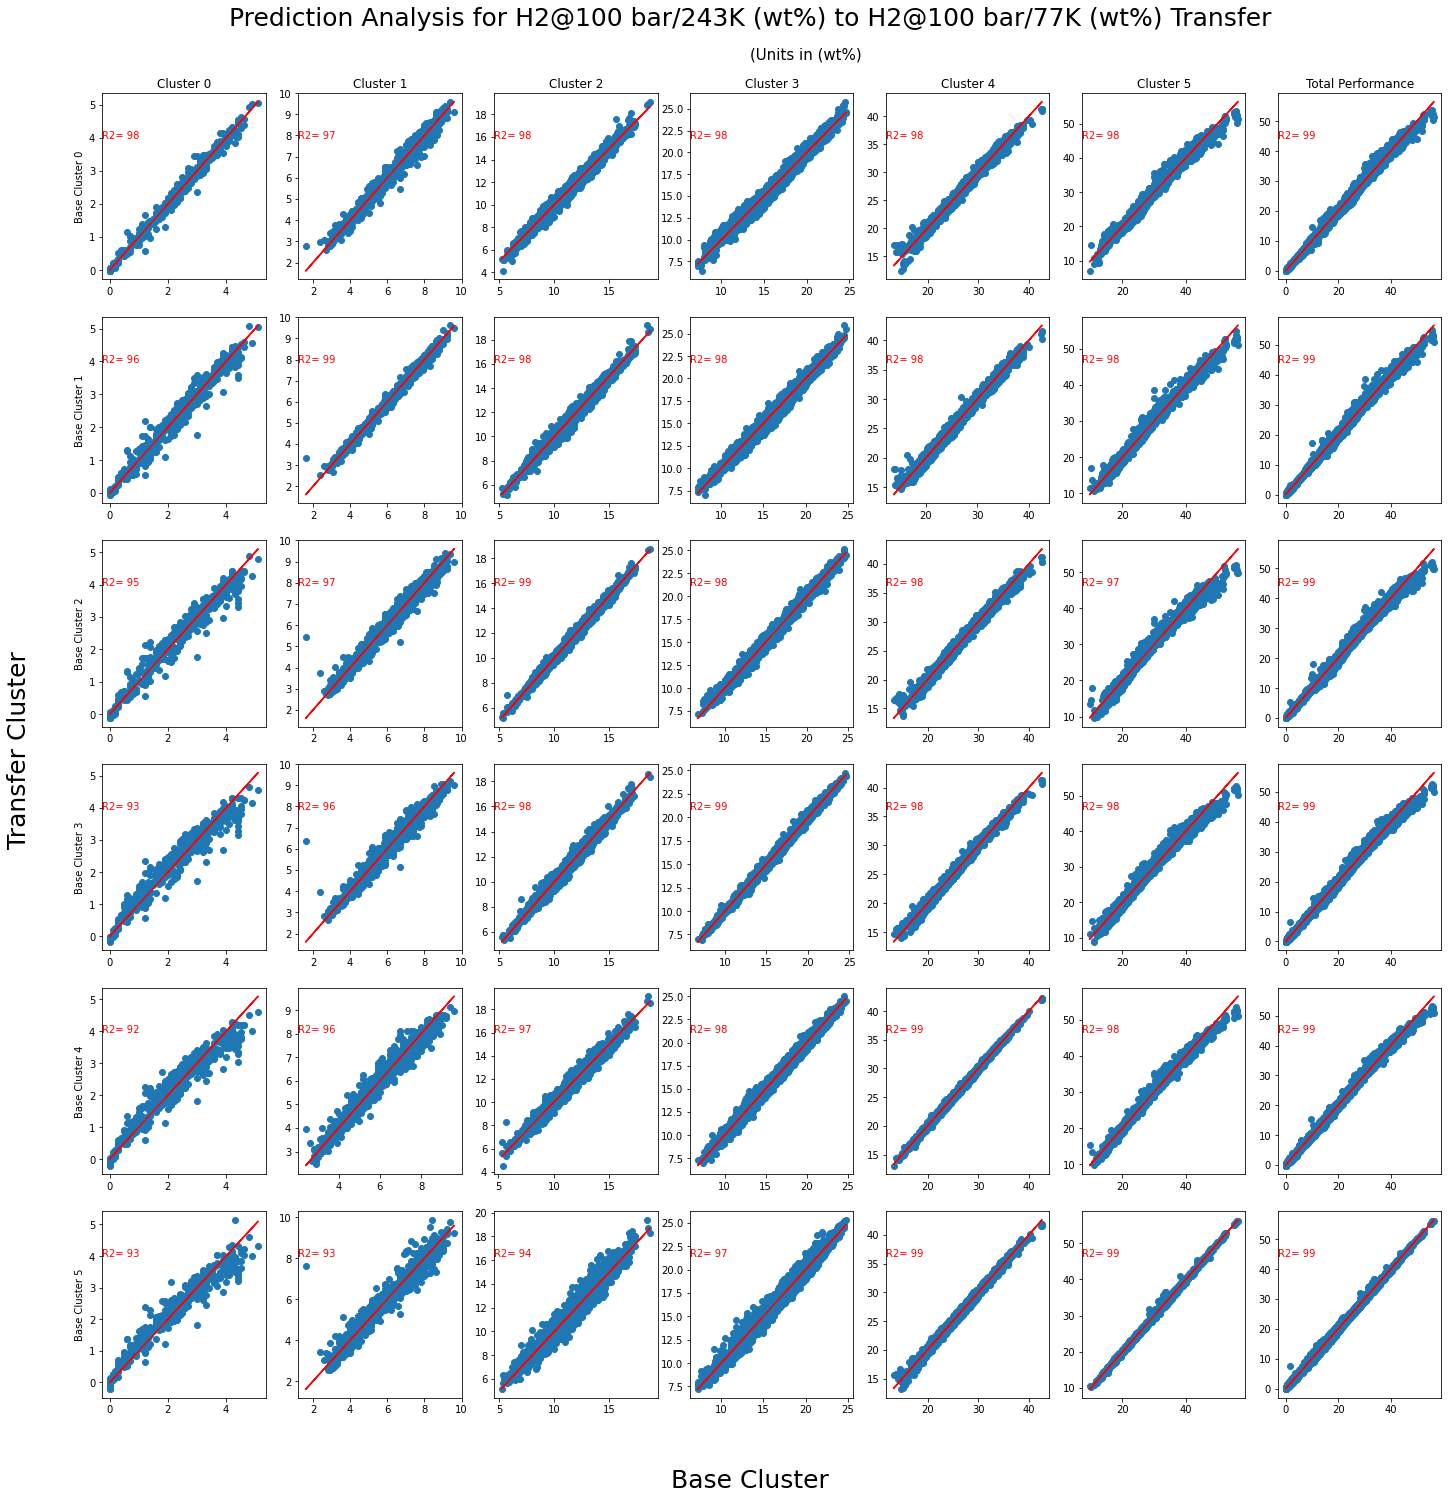

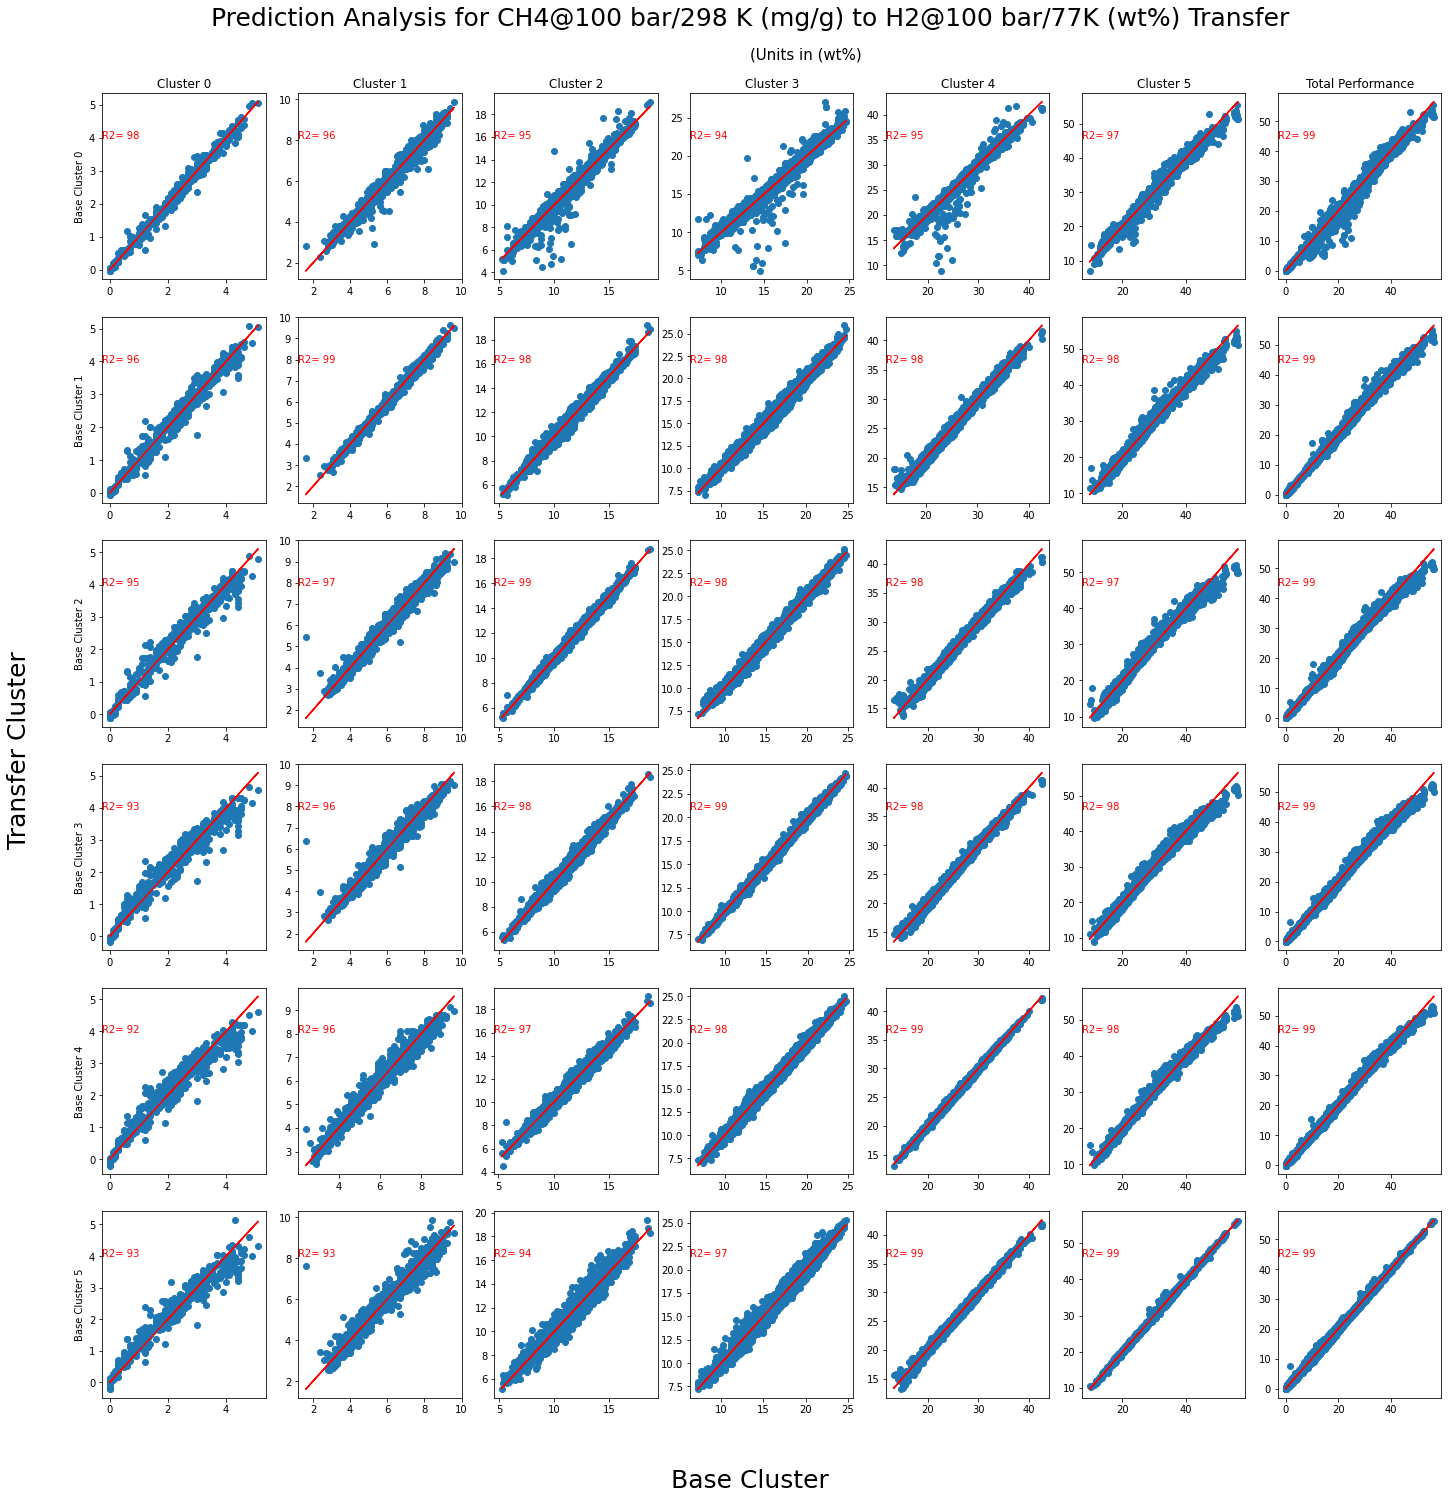

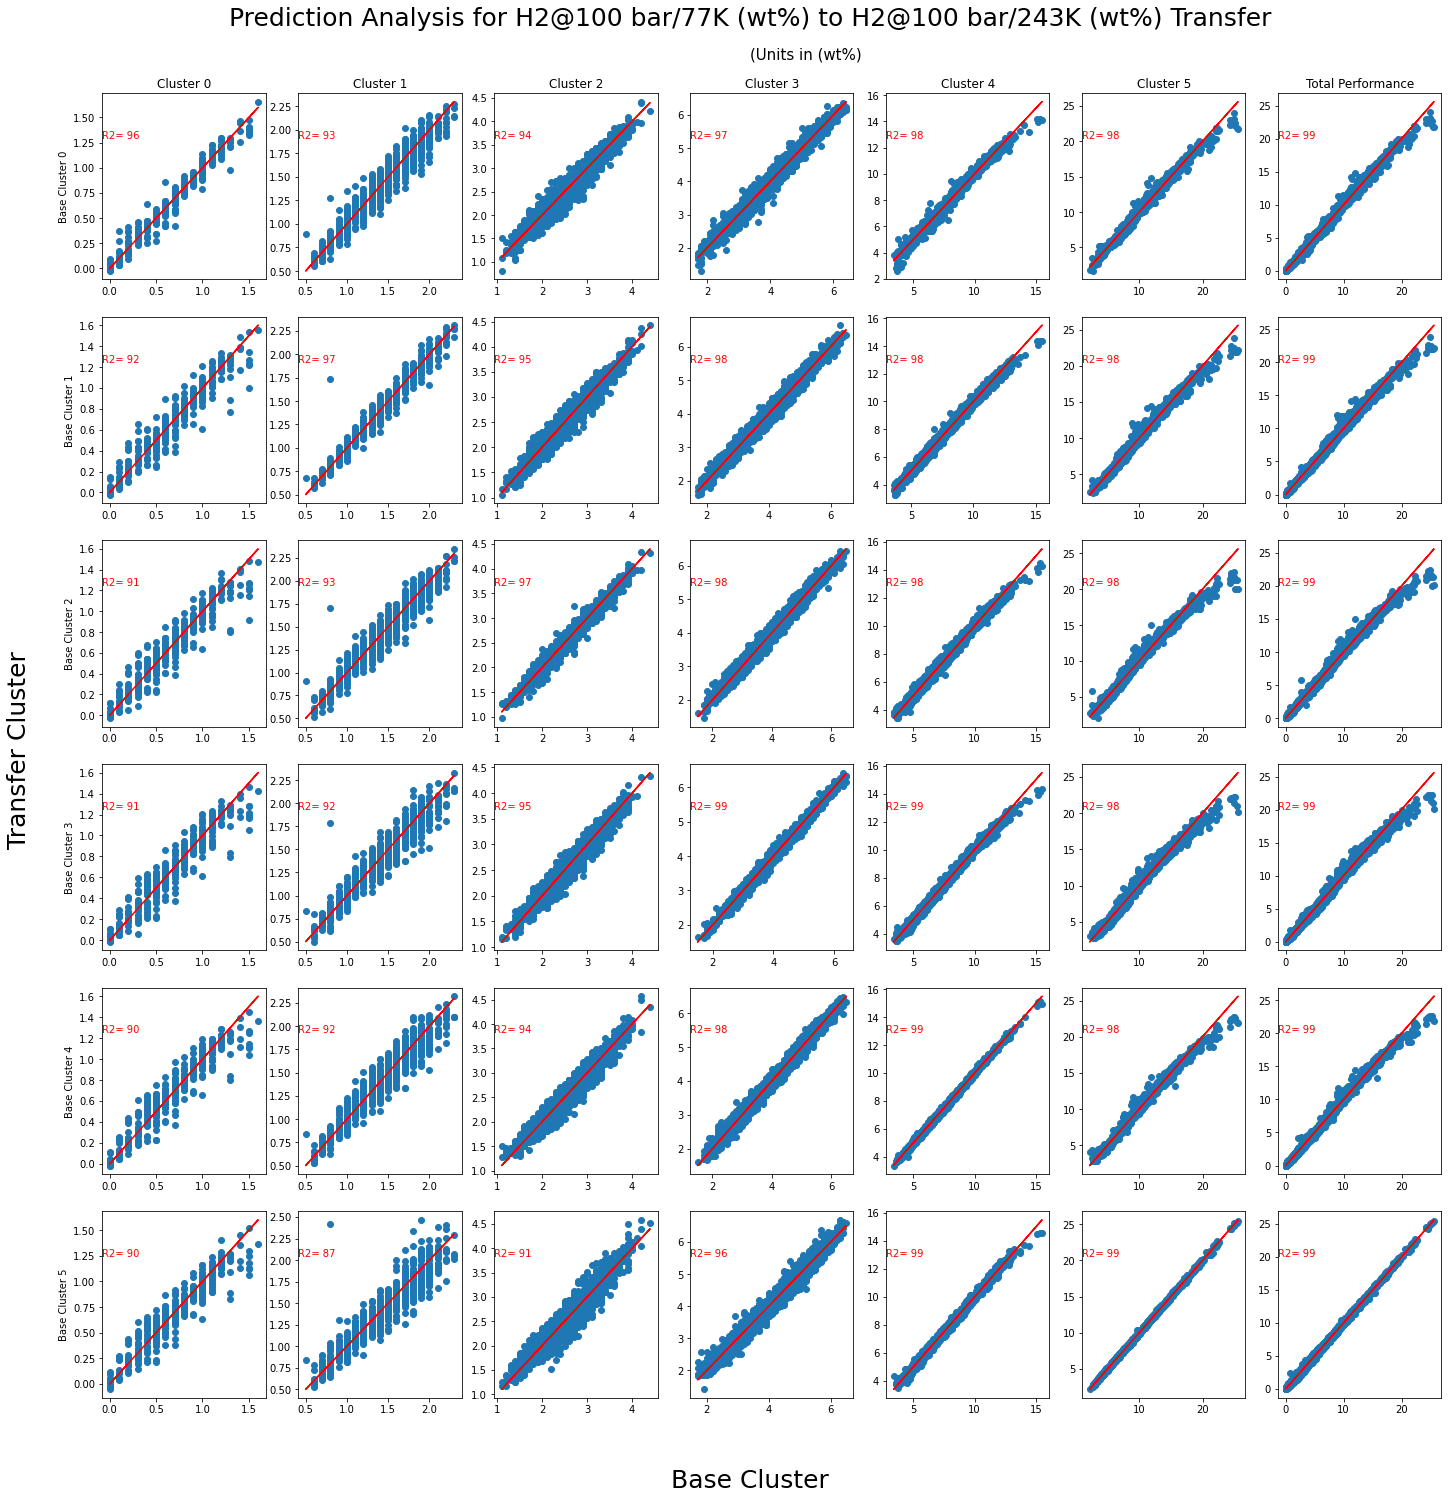

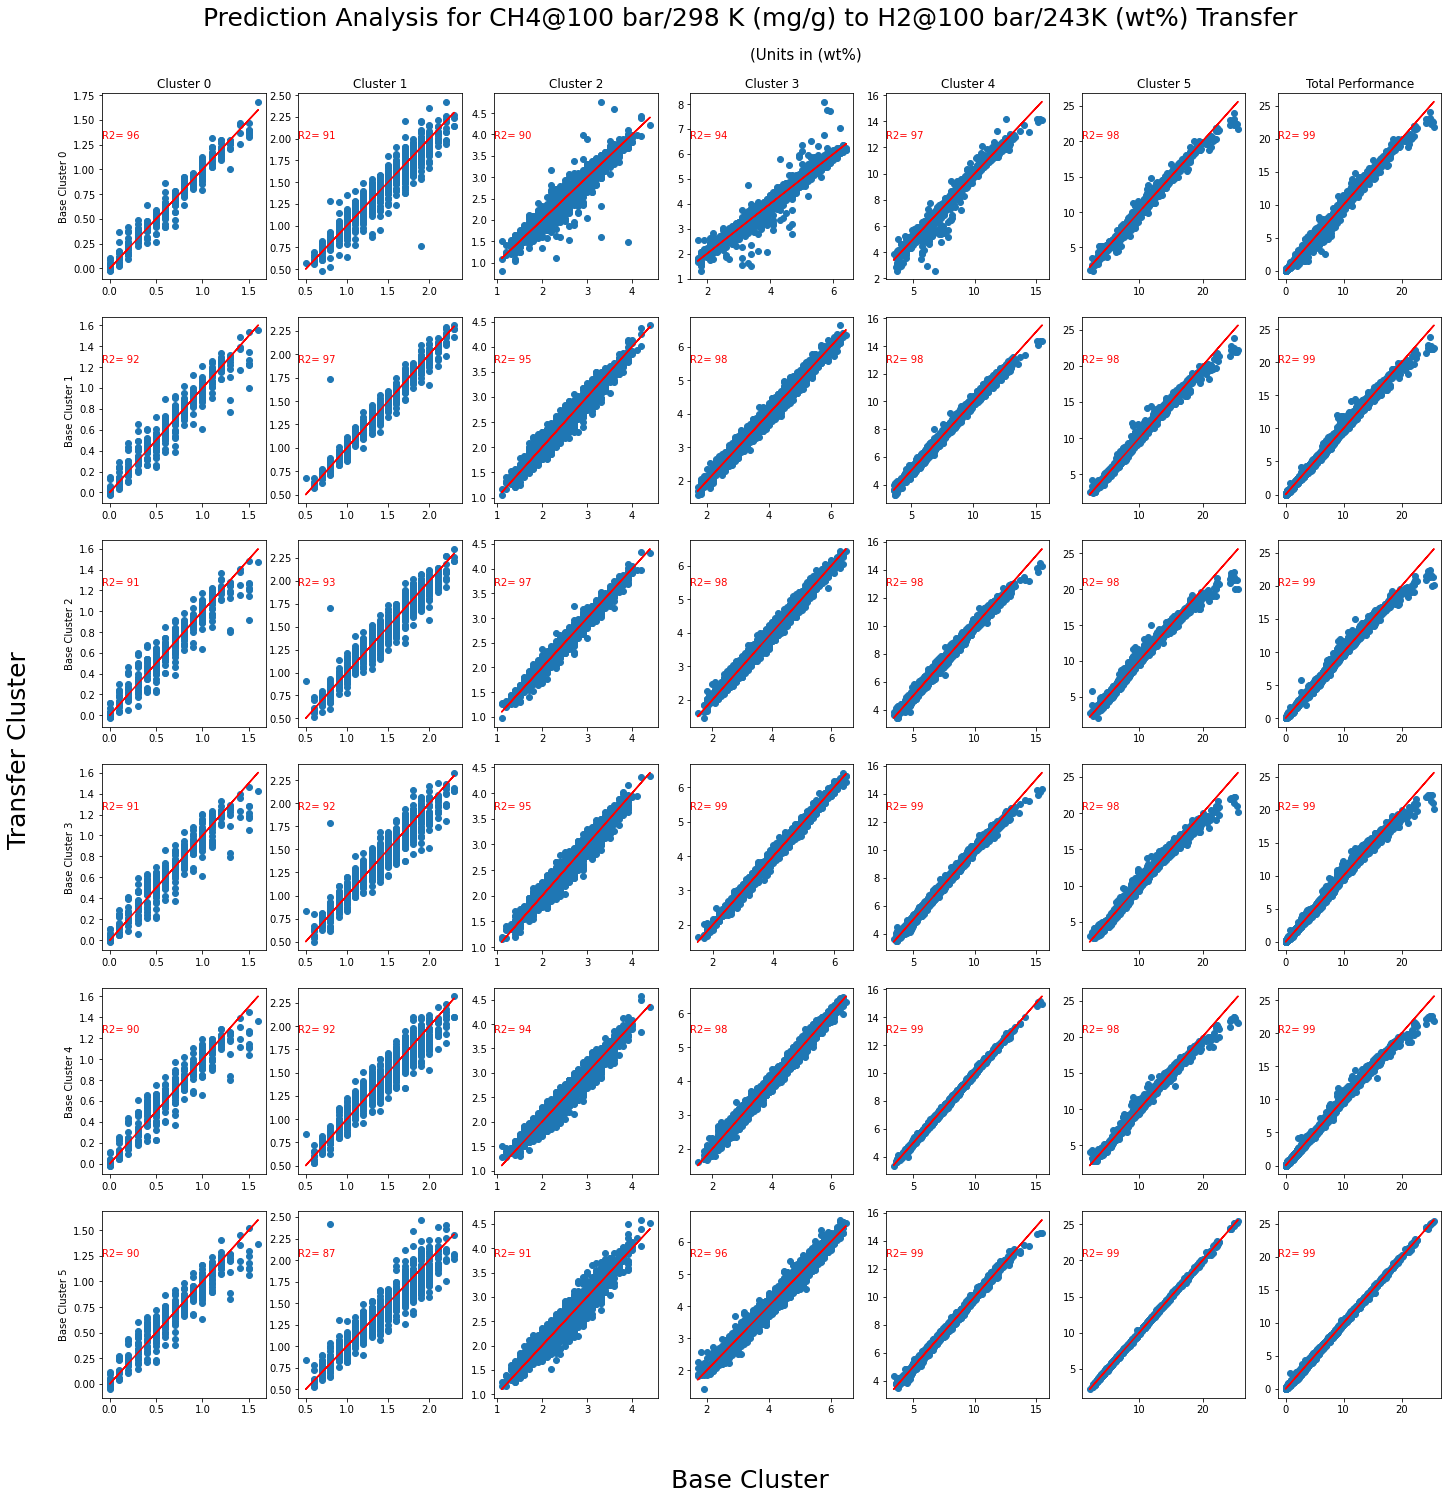

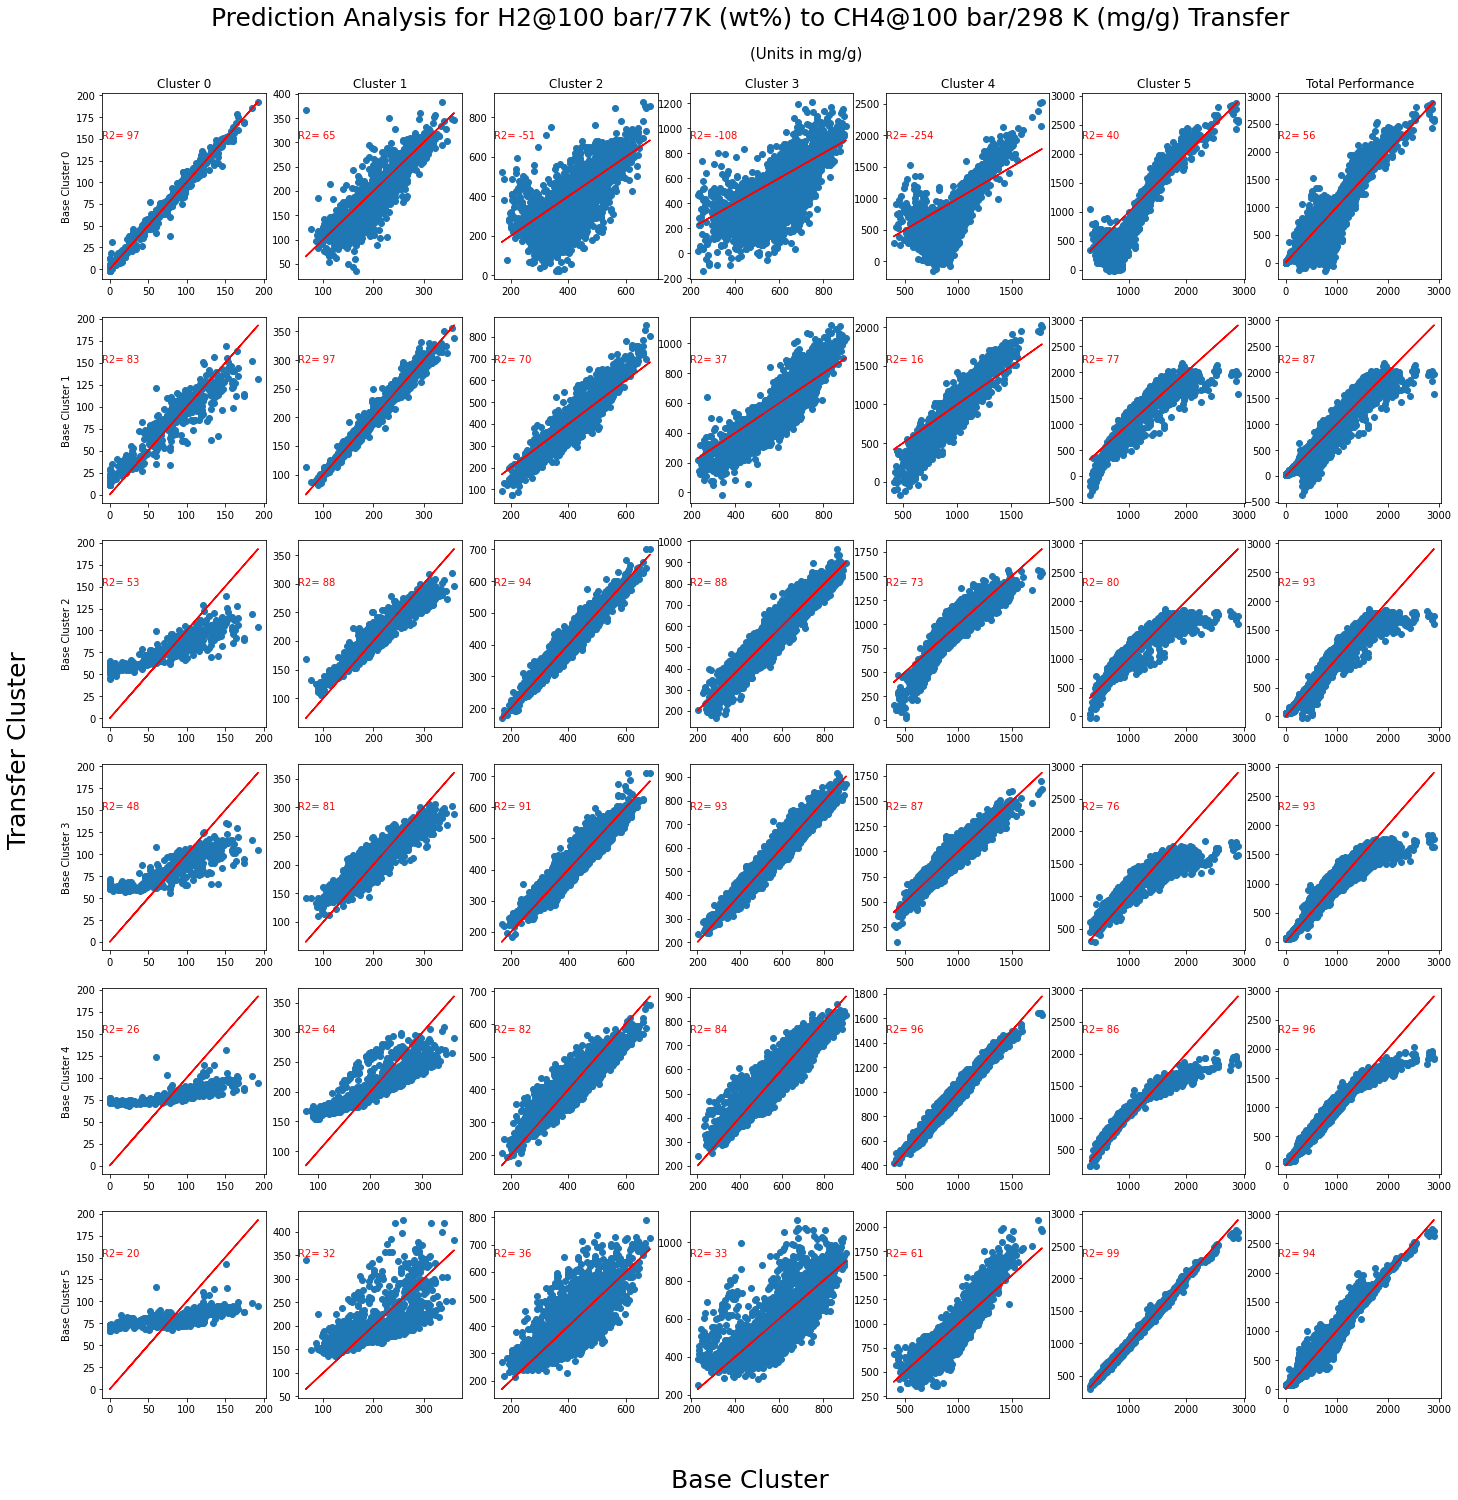

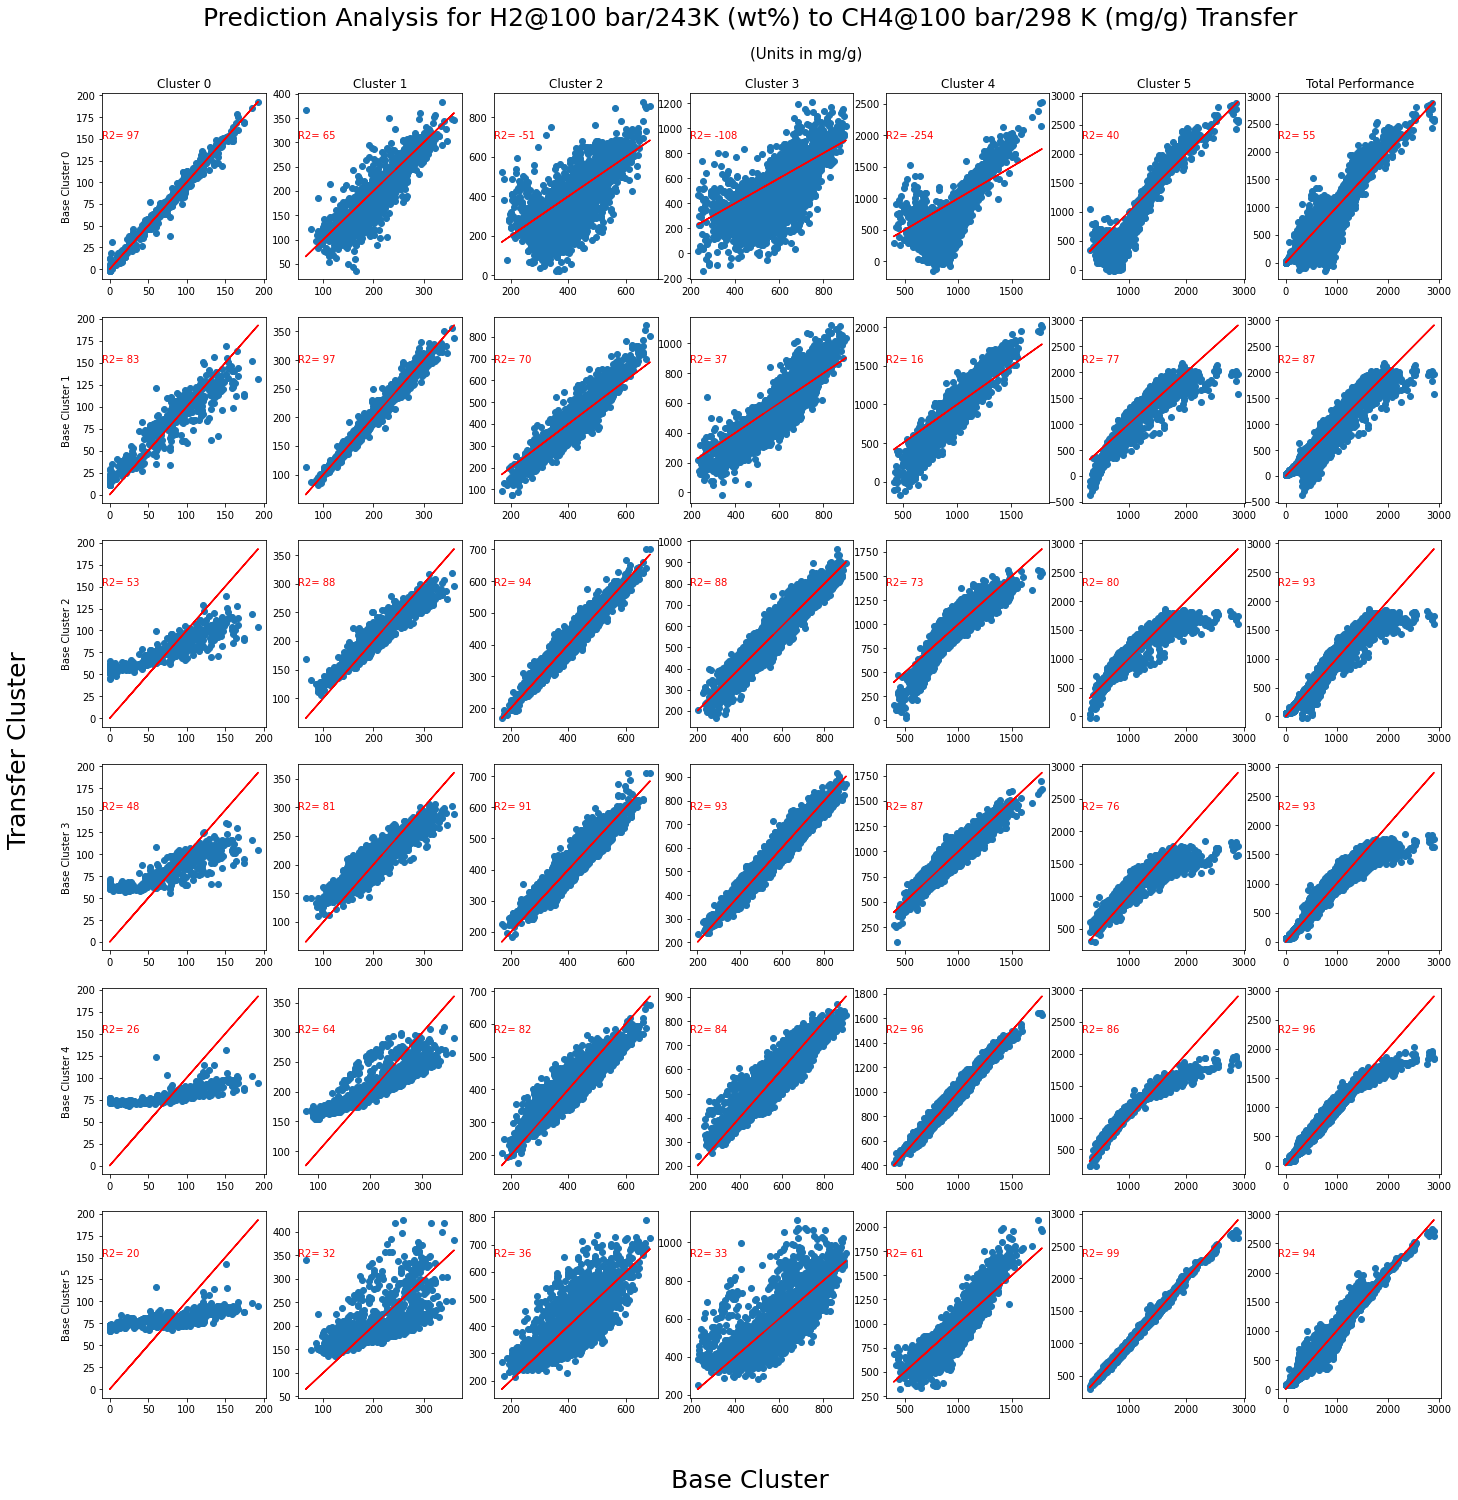

In [4]:
tests=[["H2@100 bar/77K (wt%)"],['H2@100 bar/243K (wt%)'],['CH4@100 bar/298 K (mg/g)']]
correct_names={
    "H2@100 bar/77K (wt%)":"H\u2082@77K",
    'H2@100 bar/243K (wt%)':"H\u2082@243K",
    'CH4@100 bar/298 K (mg/g)':"CH\u2084@298K"
}
for start_name in tests:
    for interest__1 in tests:
        if start_name[0]==interest__1[0]:
            pass
        else:
            transfer = interest__1
            interest=start_name
            with open(f'{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}.pickle', 'rb') as f:
                figure_dic=pickle.load(f)
            fig, axs = plt.subplots(6,7, figsize=(24,24))
            for count,g in enumerate(figure_dic):
                temp=figure_dic[str(g)]
                slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
                slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
                temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
                slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
                for i in range(6):
                    subset=slice[slice["Cluster"]==i]
                    axs[count,i].scatter(subset[interest],subset["Prediction"])
                    axs[count,i].plot(subset[interest].to_numpy(),subset[interest].to_numpy(),c="r")
                    axs[count,i].text(0,.8,"R2= "+str(int(100*r2_score(subset[interest].to_numpy(),subset["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[count,i].transAxes)
                axs[count,6].text(0,.8,"R2= "+str(int(100*r2_score(slice[interest].to_numpy(),slice["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[count,6].transAxes)
                axs[count,6].scatter(slice[interest],slice["Prediction"])
                axs[count,6].plot(slice[interest].to_numpy(),slice[interest].to_numpy(),c="r")
                axs[0,0].set_title("Cluster 0")
                axs[0,1].set_title("Cluster 1")
                axs[0,2].set_title("Cluster 2")
                axs[0,3].set_title("Cluster 3")
                axs[0,4].set_title("Cluster 4")
                axs[0,5].set_title("Cluster 5")
                axs[0,6].set_title("Total Performance")
                axs[count,0].set_ylabel(f"Base Cluster {count}")
            fig.suptitle(f'Prediction Analysis for {transfer[0]} to {interest[0]} Transfer', fontsize=25,y=.93)
            fig.text(y=.90,x=.5,s=f'(Units in {interest[0][-5:-1]})', fontsize=15)
            fig.supylabel(f'Transfer Cluster', fontsize=25,x=.07)
            fig.supxlabel(f'Base Cluster', fontsize=25,y=.07)
            fig.savefig(f'{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}_Complete.png',dpi=300)

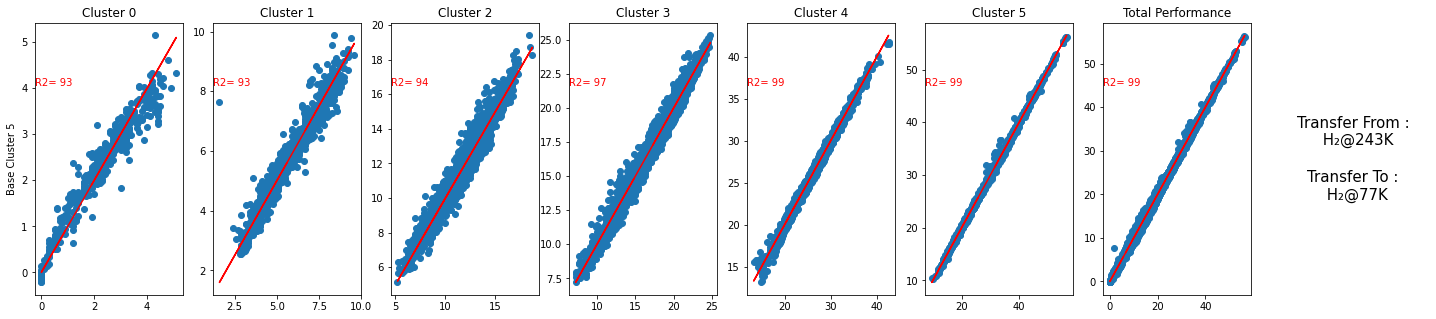

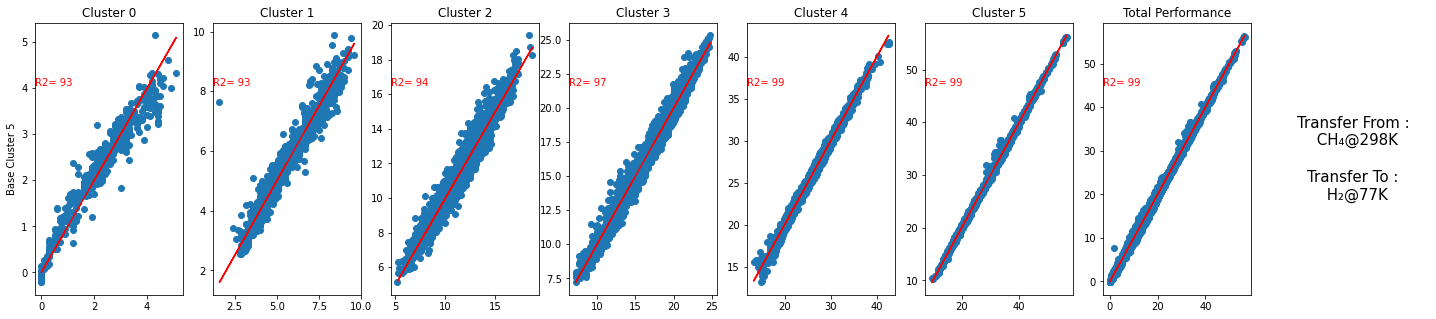

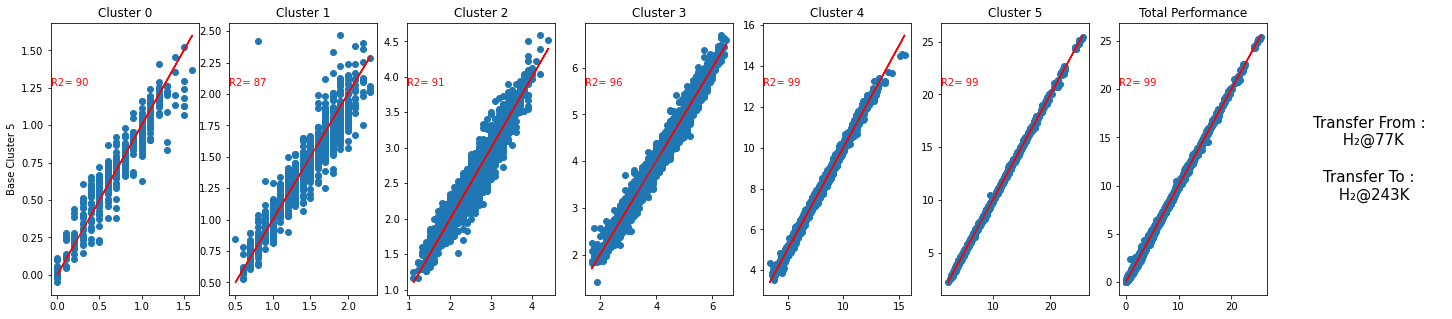

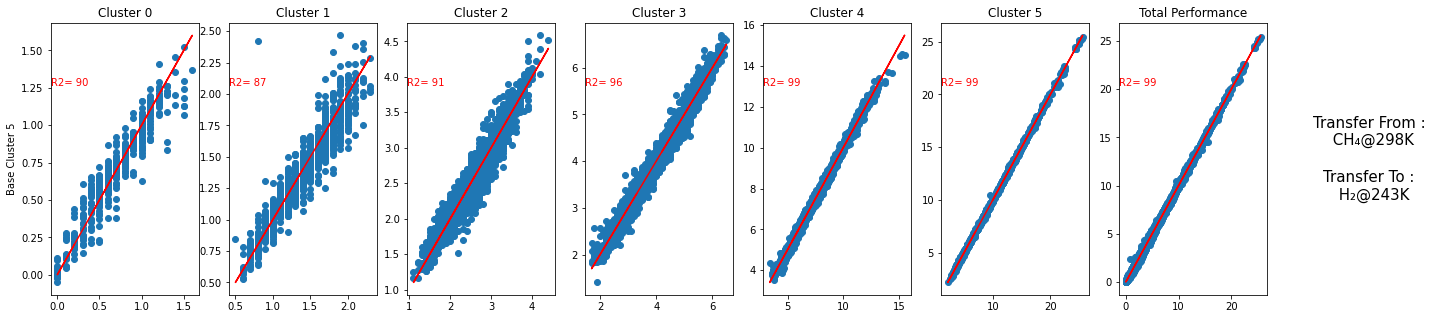

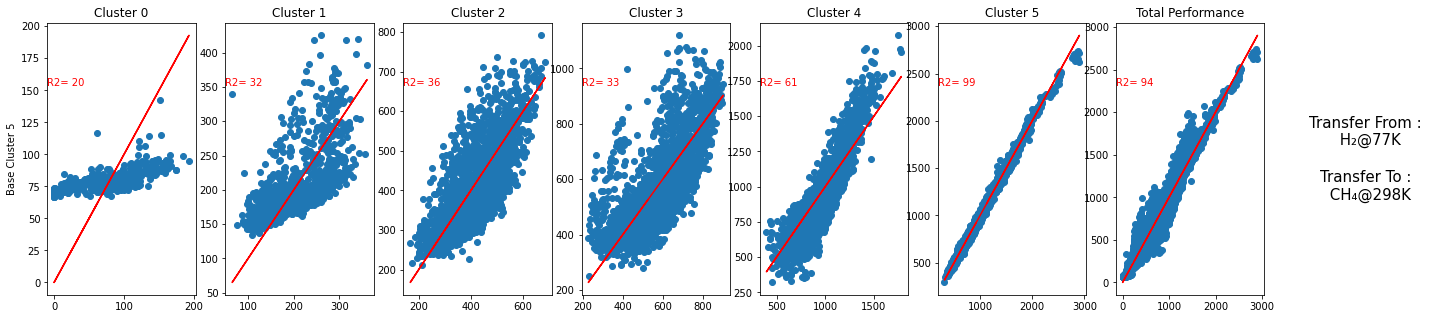

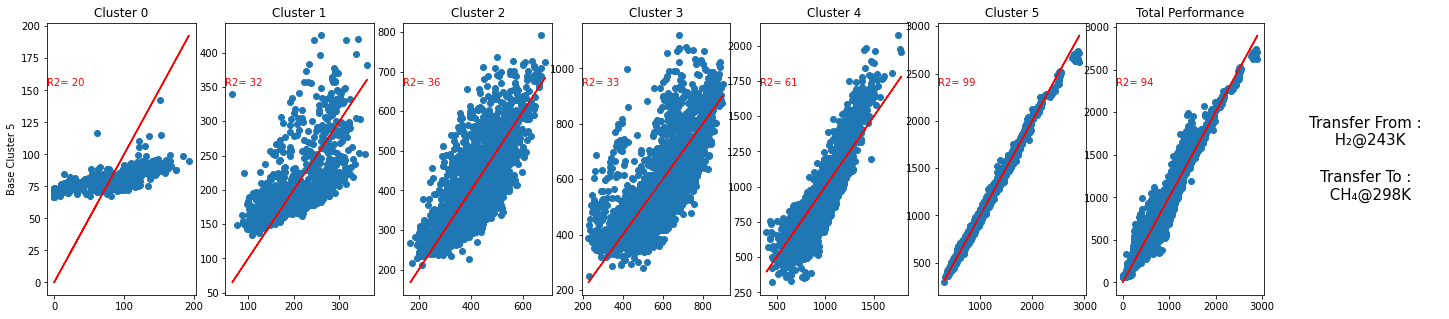

In [5]:
tests=[["H2@100 bar/77K (wt%)"],['H2@100 bar/243K (wt%)'],['CH4@100 bar/298 K (mg/g)']]
correct_names={
    "H2@100 bar/77K (wt%)":"H\u2082@77K",
    'H2@100 bar/243K (wt%)':"H\u2082@243K",
    'CH4@100 bar/298 K (mg/g)':"CH\u2084@298K"
}
for start_name in tests:
    for interest__1 in tests:
        if start_name[0]==interest__1[0]:
            pass
        else:
            transfer = interest__1
            interest=start_name
            with open(f'{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}.pickle', 'rb') as f:
                figure_dic=pickle.load(f)
            fig, axs = plt.subplots(1,8, figsize=(25,5))
            g=5
            count=5
            temp=figure_dic[str(g)]
            slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
            slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
            temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
            slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
            for i in range(6):
                subset=slice[slice["Cluster"]==i]
                axs[i].scatter(subset[interest],subset["Prediction"])
                axs[i].plot(subset[interest].to_numpy(),subset[interest].to_numpy(),c="r")
                axs[i].text(0,.8,"R2= "+str(int(100*r2_score(subset[interest].to_numpy(),subset["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[i].transAxes)
            axs[6].text(0,.8,"R2= "+str(int(100*r2_score(slice[interest].to_numpy(),slice["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[6].transAxes)
            axs[6].scatter(slice[interest],slice["Prediction"])
            axs[6].plot(slice[interest].to_numpy(),slice[interest].to_numpy(),c="r")
            axs[0].set_title("Cluster 0")
            axs[1].set_title("Cluster 1")
            axs[2].set_title("Cluster 2")
            axs[3].set_title("Cluster 3")
            axs[4].set_title("Cluster 4")
            axs[5].set_title("Cluster 5")
            axs[6].set_title("Total Performance")
            axs[0].set_ylabel(f"Base Cluster {count}")
            #fig.suptitle(f'Prediction Analysis for {transfer[0]} to {interest[0]} Transfer', fontsize=25,y=1.1)
            #fig.text(y=.98,x=.475,s=f'(Units in {interest[0][-5:-1]})', fontsize=15)
            #fig.supylabel(f'Base Cluster', fontsize=25,x=.07)
            #fig.supxlabel(f'Transfer Cluster', fontsize=25,y=-.1)
            axs[7].spines['top'].set_visible(False)
            axs[7].spines['right'].set_visible(False)
            axs[7].spines['bottom'].set_visible(False)
            axs[7].spines['left'].set_visible(False)
            axs[7].get_xaxis().set_ticks([])
            axs[7].get_yaxis().set_ticks([])
            axs[7].text(.5,.6,f'Transfer From : \n {correct_names[transfer[0]]}',ha='center', va='center', transform=axs[7].transAxes,fontsize=15)
            axs[7].text(.5,.4,f'Transfer To : \n {correct_names[interest[0]]}',ha='center', va='center', transform=axs[7].transAxes,fontsize=15)

            fig.savefig(f"{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}_{g}.png",dpi=300)
            fig.show()

In [ ]:
tests=[["H2@100 bar/77K (wt%)"],['H2@100 bar/243K (wt%)'],['CH4@100 bar/298 K (mg/g)']]
correct_names={
    "H2@100 bar/77K (wt%)":"H\u2082@77K",
    'H2@100 bar/243K (wt%)':"H\u2082@243K",
    'CH4@100 bar/298 K (mg/g)':"CH\u2084@298K"
}
for start_name in tests:
    for interest__1 in tests:
        if start_name[0]==interest__1[0]:
            pass
        else:
            transfer = interest__1
            interest=start_name
            with open(f'{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}.pickle', 'rb') as f:
                figure_dic=pickle.load(f)
            fig, axs = plt.subplots(1,8, figsize=(25,5))
            g=5
            count=5
            temp=figure_dic[str(g)]
            slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
            slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
            temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
            slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
            for i in range(6):
                subset=slice[slice["Cluster"]==i]
                plt.scatter(subset["Pc1"])
                
                

void fraction


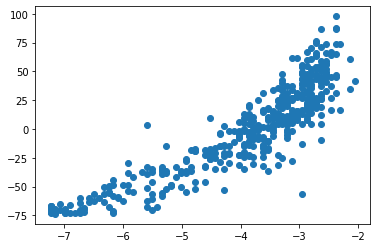

Vol. S.A.


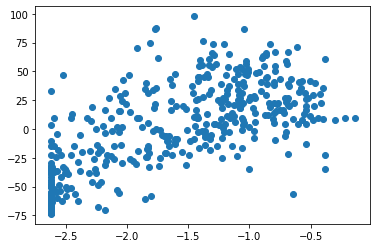

Grav. S.A.


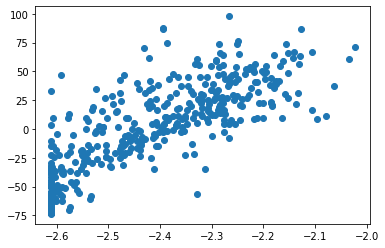

Pore diameter Limiting


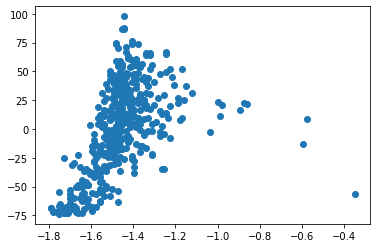

Pore diameter Largest


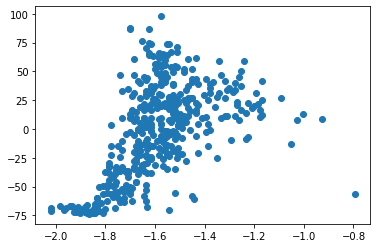

Prediction


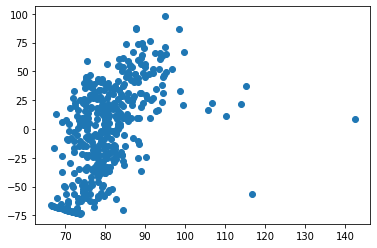

Value


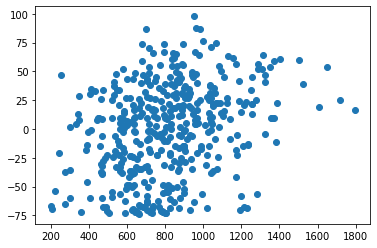

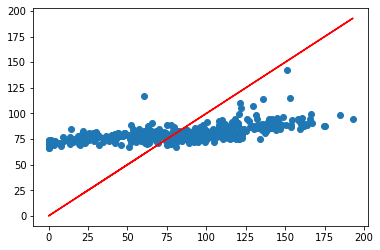

In [71]:
transfer = ['H2@100 bar/243K (wt%)']
interest=['CH4@100 bar/298 K (mg/g)']
with open(f'{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}.pickle', 'rb') as f:
    figure_dic=pickle.load(f)
g=5
i=0
temp=figure_dic[str(g)]
slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
subset=slice[slice["Cluster"]==i]
test=['void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',"Prediction","Value"]
g=subset[interest[0]]-subset["Prediction"]
for i in test:
    print(i)
    plt.scatter(subset[i],g)
    plt.show()
plt.scatter(subset[interest[0]],subset["Prediction"])
plt.plot(subset[interest[0]].to_numpy(),subset[interest].to_numpy(),c="r")

In [59]:
(subset[interest].to_numpy()-subset["Prediction"].to_numpy())

(1699, 1699)

In [67]:
subset[interest[0]]-subset["Prediction"]

341       12.445776
342       52.975732
343       18.110433
344       51.668685
345       27.644995
            ...    
13449     30.886373
13450     -9.222607
13452   -216.553870
13498      0.052161
13499     -0.766840
Length: 1699, dtype: float64

0
1
2
3
4
5


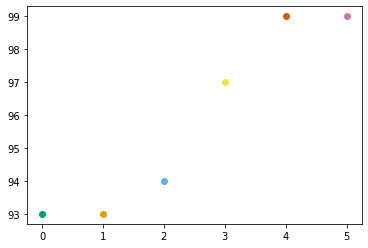

0
1
2
3
4
5


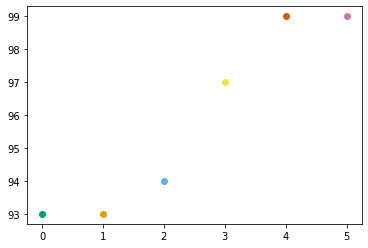

0
1
2
3
4
5


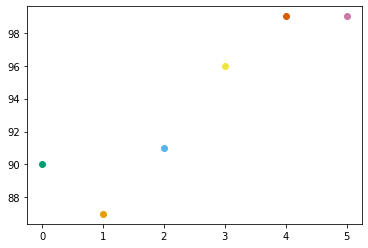

0
1
2
3
4
5


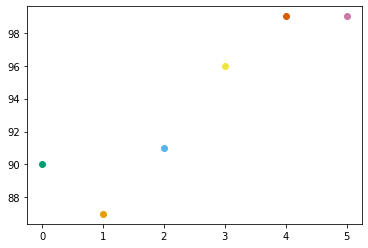

0
1
2
3
4
5


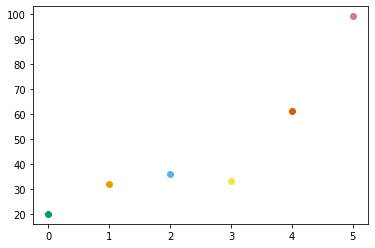

0
1
2
3
4
5


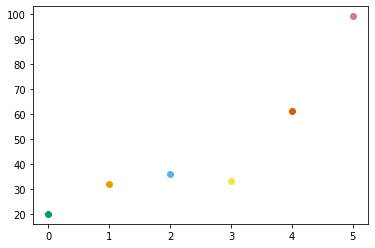

In [12]:
tests=[["H2@100 bar/77K (wt%)"],['H2@100 bar/243K (wt%)'],['CH4@100 bar/298 K (mg/g)']]
correct_names={
    "H2@100 bar/77K (wt%)":"H\u2082@77K",
    'H2@100 bar/243K (wt%)':"H\u2082@243K",
    'CH4@100 bar/298 K (mg/g)':"CH\u2084@298K"
}
for start_name in tests:
    for interest__1 in tests:
        if start_name[0]==interest__1[0]:
            pass
        else:
            transfer = interest__1
            interest=start_name
            with open(f'{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}.pickle', 'rb') as f:
                figure_dic=pickle.load(f)
            g=5
            count=5
            temp=figure_dic[str(g)]
            slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
            slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
            temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
            slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
            for i in range(6):
                subset=slice[slice["Cluster"]==i]
                print(i)
                plt.scatter(i,int(100*r2_score(subset[interest].to_numpy(),subset["Prediction"].to_numpy())),c=Cluster_colors[i])
            plt.show()
            #fig.savefig(f"{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}_{g}.png",dpi=300)
            fig.show()

In [5]:
Cluster_colors=[
"#009E73",
"#E69F00",
"#56B4E9",
"#F0E442",
"#D55E00",
"#CC79A7"]
def map_colors(df,colors):
    dic={}
    for i in df["Cluster"].unique():
        dic[i]=colors[i]
    df["color"]=df["Cluster"].map(dic)
    return df

In [6]:
def plot_hull(data2,ax,g):
    from scipy.spatial import ConvexHull, convex_hull_plot_2d
    alpha_tuples=[[a,b] for a,b in zip(data2["Pc1"].to_numpy(),data2["Pc2"].to_numpy())]
    alpha_tuples=np.array(alpha_tuples)
    hull=ConvexHull(alpha_tuples)
    #ax[g].plot(alpha_tuples[:,0], alpha_tuples[:,1], 'o')
    #ax[g].plot(alpha_tuples[hull.vertices,0], alpha_tuples[hull.vertices,1], 'r--', lw=2)
    #ax[g].plot(alpha_tuples[hull.vertices[0],0], alpha_tuples[hull.vertices[0],1], 'ro')
    #ax[g].plot(alpha_tuples[:,0], alpha_tuples[:,1], 'o')
    #ax[g].plot(alpha_tuples[hull.vertices,0], alpha_tuples[hull.vertices,1], 'r--', lw=2)
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    ax[g].plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    ax[g].plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    ax[g].plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    ax[g].plot(x,y(x),'r--', lw=2)
    ax[g].plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)

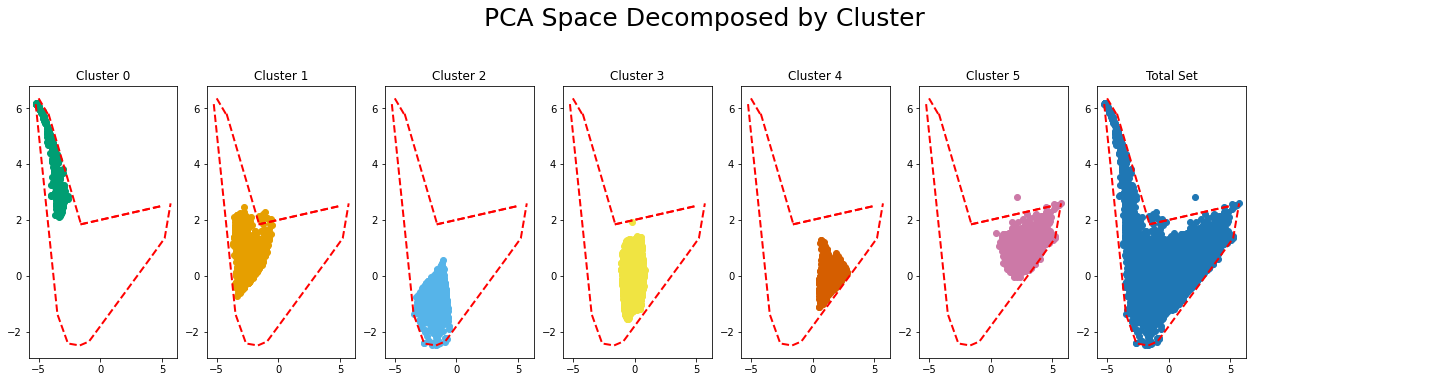

In [142]:
fig, axs = plt.subplots(1,8, figsize=(25,5))
g=5
count=5
temp=figure_dic[str(g)]
slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
for i in range(6):
    subset=slice[slice["Cluster"]==i]
    axs[i].scatter(subset["Pc1"],subset["Pc2"],c=Cluster_colors[i])
    plot_hull(abridge,axs,i)
    #axs[i].plot(subset[interest].to_numpy(),subset[interest].to_numpy(),c="r")
    #axs[i].text(0,.8,"R2= "+str(int(100*r2_score(subset[interest].to_numpy(),subset["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[i].transAxes)
#axs[6].text(0,.8,"R2= "+str(int(100*r2_score(slice[interest].to_numpy(),slice["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[6].transAxes)
axs[6].scatter(slice["Pc1"],slice["Pc2"])
plot_hull(abridge,axs,6)
#axs[6].plot(slice["Pc1"].to_numpy(),slice["Pc2"].to_numpy(),c="r")
axs[0].set_title("Cluster 0")
axs[1].set_title("Cluster 1")
axs[2].set_title("Cluster 2")
axs[3].set_title("Cluster 3")
axs[4].set_title("Cluster 4")
axs[5].set_title("Cluster 5")
axs[6].set_title("Total Set")
axs[7].spines['top'].set_visible(False)
axs[7].spines['right'].set_visible(False)
axs[7].spines['bottom'].set_visible(False)
axs[7].spines['left'].set_visible(False)
axs[7].get_xaxis().set_ticks([])
axs[7].get_yaxis().set_ticks([])
fig.suptitle(f'PCA Space Decomposed by Cluster', fontsize=25,y=1.1)
fig.savefig("PCA_Space.png",dpi=300)

Text(0.5, 0.98, 'Space Analysis for H2@100 bar/243K (wt%) to CH4@100 bar/298 K (mg/g) Transfer')

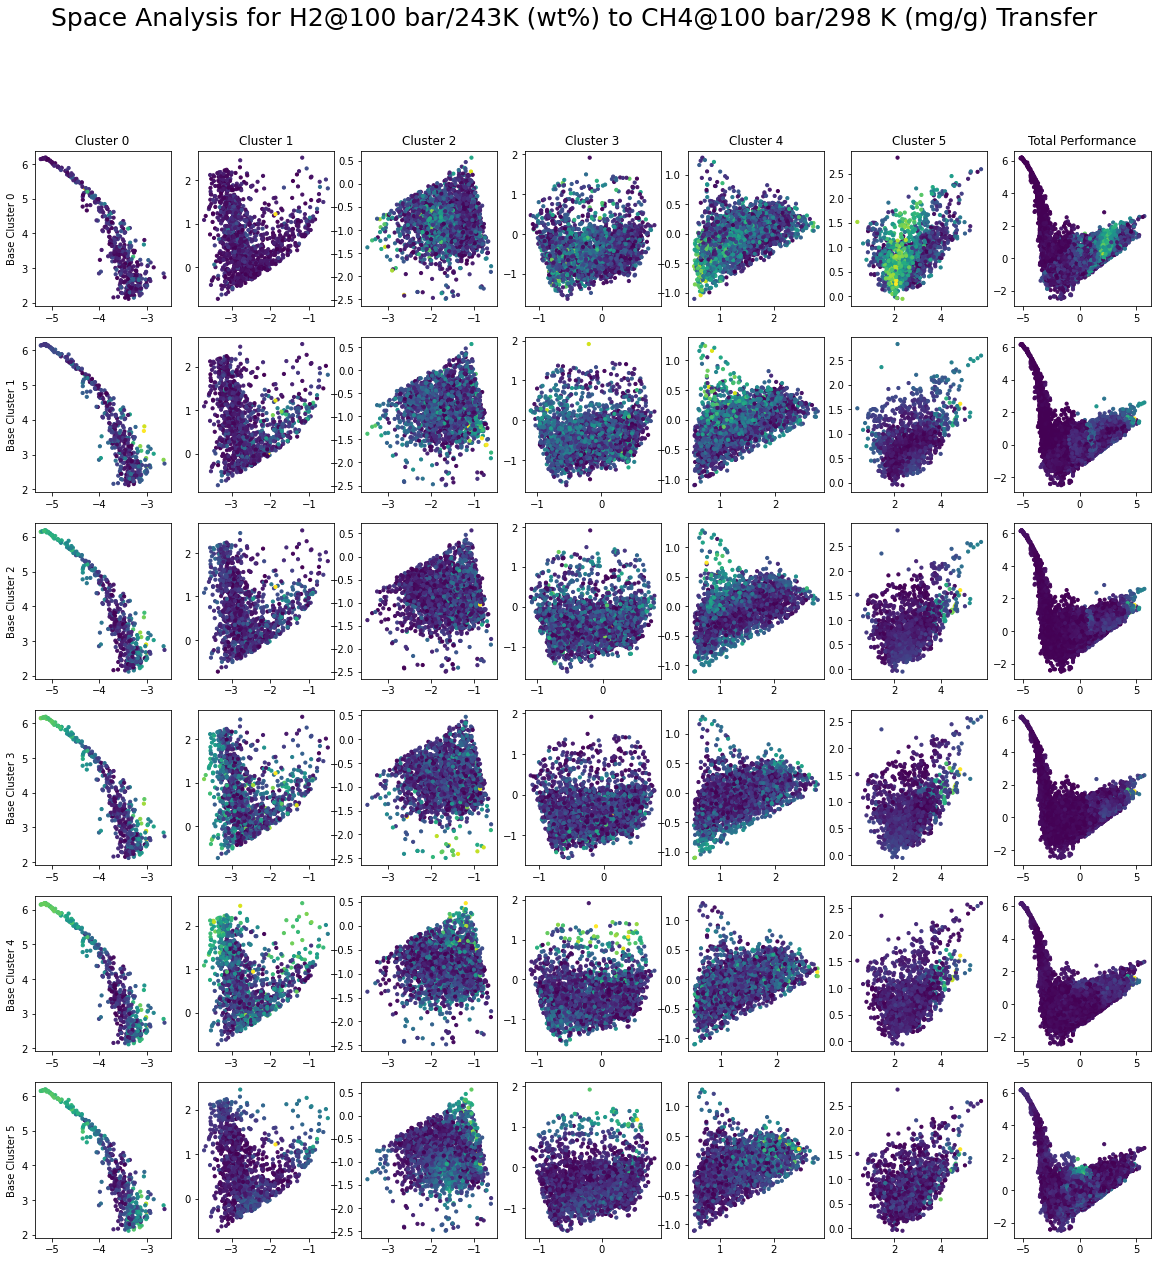

In [17]:
fig, axs = plt.subplots(6,7, figsize=(20,20))
for count,g in enumerate(figure_dic):
    temp=figure_dic[str(g)]
    slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
    slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
    temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
    slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
    slice["Error"]=slice.apply(lambda x: abs(x[interest]-x["Prediction"]),axis=1)
    for i in range(6):
        subset=slice[slice["Cluster"]==i]
        axs[count,i].scatter(subset["Pc1"],subset["Pc2"],cmap="viridis",c=subset["Error"],s=10)
    axs[count,6].scatter(slice["Pc1"],slice["Pc2"],cmap="viridis",c=slice["Error"],s=10)
    axs[0,0].set_title("Cluster 0")
    axs[0,1].set_title("Cluster 1")
    axs[0,2].set_title("Cluster 2")
    axs[0,3].set_title("Cluster 3")
    axs[0,4].set_title("Cluster 4")
    axs[0,5].set_title("Cluster 5")
    axs[0,6].set_title("Total Performance")
    axs[count,0].set_ylabel(f"Base Cluster {count}")
fig.suptitle(f'Space Analysis for {transfer[0]} to {interest[0]} Transfer', fontsize=25)

In [22]:
data[['H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)']].corr()

H2@100 bar/77K (wt%)  H2@100 bar/243K (wt%)  \
H2@100 bar/77K (wt%)                  1.000000               0.978722   
H2@100 bar/243K (wt%)                 0.978722               1.000000   
CH4@100 bar/298 K (mg/g)              0.988319               0.989544   

                          CH4@100 bar/298 K (mg/g)  
H2@100 bar/77K (wt%)                      0.988319  
H2@100 bar/243K (wt%)                     0.989544  
CH4@100 bar/298 K (mg/g)                  1.000000

In [30]:
loud=[0,0,0,0,0,0]
#make clusters the same size with a random sample
resize=True
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID','H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)','topology']]=data[['MOF ID','H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)','topology']]
#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)','topology', 'Pc1', 'Pc2', 'Cluster']]
abridge["MOF ID"]=abridge.index

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]

In [38]:
for count,i in enumerate(O_M_Cluster):
    print(count)
    display(i[['H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)',"Pc1","Pc2"]].corr())

0


H2@100 bar/77K (wt%)  H2@100 bar/243K (wt%)  \
H2@100 bar/77K (wt%)                  1.000000               0.936206   
H2@100 bar/243K (wt%)                 0.936206               1.000000   
CH4@100 bar/298 K (mg/g)              0.974905               0.942552   
Pc1                                   0.907362               0.856351   
Pc2                                  -0.884325              -0.760575   

                          CH4@100 bar/298 K (mg/g)       Pc1       Pc2  
H2@100 bar/77K (wt%)                      0.974905  0.907362 -0.884325  
H2@100 bar/243K (wt%)                     0.942552  0.856351 -0.760575  
CH4@100 bar/298 K (mg/g)                  1.000000  0.893098 -0.860493  
Pc1                                       0.893098  1.000000 -0.912007  
Pc2                                      -0.860493 -0.912007  1.000000

1


H2@100 bar/77K (wt%)  H2@100 bar/243K (wt%)  \
H2@100 bar/77K (wt%)                  1.000000               0.937438   
H2@100 bar/243K (wt%)                 0.937438               1.000000   
CH4@100 bar/298 K (mg/g)              0.971123               0.962351   
Pc1                                   0.684493               0.579704   
Pc2                                  -0.572806              -0.463762   

                          CH4@100 bar/298 K (mg/g)       Pc1       Pc2  
H2@100 bar/77K (wt%)                      0.971123  0.684493 -0.572806  
H2@100 bar/243K (wt%)                     0.962351  0.579704 -0.463762  
CH4@100 bar/298 K (mg/g)                  1.000000  0.585325 -0.574410  
Pc1                                       0.585325  1.000000 -0.079268  
Pc2                                      -0.574410 -0.079268  1.000000

2


H2@100 bar/77K (wt%)  H2@100 bar/243K (wt%)  \
H2@100 bar/77K (wt%)                  1.000000               0.988381   
H2@100 bar/243K (wt%)                 0.988381               1.000000   
CH4@100 bar/298 K (mg/g)              0.978519               0.983183   
Pc1                                   0.790310               0.773010   
Pc2                                  -0.482096              -0.463452   

                          CH4@100 bar/298 K (mg/g)       Pc1       Pc2  
H2@100 bar/77K (wt%)                      0.978519  0.790310 -0.482096  
H2@100 bar/243K (wt%)                     0.983183  0.773010 -0.463452  
CH4@100 bar/298 K (mg/g)                  1.000000  0.706160 -0.515536  
Pc1                                       0.706160  1.000000  0.008914  
Pc2                                      -0.515536  0.008914  1.000000

3


H2@100 bar/77K (wt%)  H2@100 bar/243K (wt%)  \
H2@100 bar/77K (wt%)                  1.000000               0.991741   
H2@100 bar/243K (wt%)                 0.991741               1.000000   
CH4@100 bar/298 K (mg/g)              0.976484               0.963171   
Pc1                                   0.598093               0.657321   
Pc2                                  -0.629985              -0.545384   

                          CH4@100 bar/298 K (mg/g)       Pc1       Pc2  
H2@100 bar/77K (wt%)                      0.976484  0.598093 -0.629985  
H2@100 bar/243K (wt%)                     0.963171  0.657321 -0.545384  
CH4@100 bar/298 K (mg/g)                  1.000000  0.515253 -0.678039  
Pc1                                       0.515253  1.000000  0.133347  
Pc2                                      -0.678039  0.133347  1.000000

4


H2@100 bar/77K (wt%)  H2@100 bar/243K (wt%)  \
H2@100 bar/77K (wt%)                  1.000000               0.991440   
H2@100 bar/243K (wt%)                 0.991440               1.000000   
CH4@100 bar/298 K (mg/g)              0.985968               0.978517   
Pc1                                   0.745692               0.785566   
Pc2                                  -0.045392               0.057367   

                          CH4@100 bar/298 K (mg/g)       Pc1       Pc2  
H2@100 bar/77K (wt%)                      0.985968  0.745692 -0.045392  
H2@100 bar/243K (wt%)                     0.978517  0.785566  0.057367  
CH4@100 bar/298 K (mg/g)                  1.000000  0.731622 -0.079851  
Pc1                                       0.731622  1.000000  0.450442  
Pc2                                      -0.079851  0.450442  1.000000

5


H2@100 bar/77K (wt%)  H2@100 bar/243K (wt%)  \
H2@100 bar/77K (wt%)                  1.000000               0.989252   
H2@100 bar/243K (wt%)                 0.989252               1.000000   
CH4@100 bar/298 K (mg/g)              0.984990               0.994165   
Pc1                                   0.742842               0.734534   
Pc2                                   0.005393               0.065860   

                          CH4@100 bar/298 K (mg/g)       Pc1       Pc2  
H2@100 bar/77K (wt%)                      0.984990  0.742842  0.005393  
H2@100 bar/243K (wt%)                     0.994165  0.734534  0.065860  
CH4@100 bar/298 K (mg/g)                  1.000000  0.718629 -0.004820  
Pc1                                       0.718629  1.000000  0.412514  
Pc2                                      -0.004820  0.412514  1.000000